# **Many-to-One LSTM**

In [ ]:
!pip install muspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.2 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=9539b36d119a837837b5ac9b7d0a95ebc92f92a90f79e13c4e7c3d78229a5746
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import muspy
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")

Using device: cuda
GPU Name: NVIDIA L4
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Let's again load the metadata:

In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0.csv")

The dataset used here is the same as the one in the Many-to-one GRU. Let's define it:

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, metadata, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.songs = []

        for file in metadata["midi_filename"]:
            file_path = os.path.join("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0-midi/maestro-v3.0.0/", file)
            muspy_file = muspy.read(file_path)
            self.songs.append(muspy_file)

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        pianoroll_song = self.songs[idx].to_pianoroll_representation()
        pianoroll_song = torch.tensor(pianoroll_song, dtype=torch.float32)

        start_idx = random.randint(0, len(pianoroll_song) - self.seq_len - 1)

        input_seq = pianoroll_song[start_idx:start_idx+self.seq_len]

        target = pianoroll_song[start_idx+self.seq_len]

        return input_seq, target

In [ ]:
music_dataset_train = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/train/music_dataset_train_many_to_one_muspy.pt", weights_only=False)
music_dataset_val = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/validation/music_dataset_val_many_to_one_muspy.pt", weights_only=False)

Here we define the model. The main difference with the GRU architecture here is, that the linear layer takes the hidden state, instead of the output of the LSTM layer.

In [ ]:
class ManyToOneLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(ManyToOneLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (h_n, c_n) = self.lstm(x, (h0, c0))
        out = self.fc(h_n[-1])

        return out

We have to define the same collate function here.

In [ ]:
def collate_fn_packed(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None, None

    sequences, targets = zip(*batch)

    seq_lengths = torch.tensor([s.shape[0] for s in sequences], dtype=torch.long)

    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0.0)

    return sequences_padded, targets_padded, seq_lengths

Again, loading the datasets:

In [ ]:
music_dataloader_train = DataLoader(music_dataset_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
music_dataloader_val = DataLoader(music_dataset_val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Now it's time to initialize the model with an input size of 128, just like the number of different tones for the piano-roll data. The hidden size is 256, the number of layers is 2 and the output size is 128 in order to output a new time step.

In [ ]:
many_to_one_lstm = ManyToOneLSTM(128, 256, 128, 2).to(device)

optimizer = optim.AdamW(many_to_one_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

The train function is essentially the same as the one used in the Many-to-one GRU.

In [ ]:
def train_many_to_one_lstm(net, optimizer, criterion, num_epochs, train_loss_history=[], val_loss_history=[], create_plot=False):
    net.train()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for sequences, targets in tqdm(music_dataloader_train, f"Epoch {epoch+1}:"):
            sequences = sequences.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            sequences = sequences.reshape(-1, 100, 128)
            targets = targets.reshape(-1, 128)

            outputs = net(sequences)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(music_dataloader_train)
        train_loss_history.append(avg_loss)
        print(f"Average Train Loss: {avg_loss:.4f}")

        net.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for sequences, targets in music_dataloader_val:
                sequences = sequences.to(device)
                targets = targets.to(device)
                outputs = net(sequences)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(music_dataloader_val)
        val_loss_history.append(avg_val_loss)
        print(f"Average Validation Loss: {avg_val_loss:.4f}")
        net.train()


        if (len(train_loss_history) % 10) == 0:
            torch.save(net.state_dict(), f"/content/drive/MyDrive/Piano generation/Project/saved_data/saved_models/many_to_one_lstm_third_try_epoch_{len(train_loss_history)}.pt")

    if create_plot:
        plt.plot(train_loss_history, label="Training loss")
        plt.plot(val_loss_history, label="Validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.show()
        plt.savefig(f"/content/drive/MyDrive/Piano generation/Project/saved_data/plots/many_to_one_lstm_loss_epoch_{len(train_loss_history)}_plot.png")

    return train_loss_history, val_loss_history

Again, let's take a look at the first 10 epochs:

<ipython-input-12-4cbeee087625>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 58.7680


Average Validation Loss: 63.8718


Epoch 2:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 54.1596


Average Validation Loss: 48.4994


Epoch 3:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 50.3820


Average Validation Loss: 47.4634


Epoch 4:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]


Average Train Loss: 47.1099
Average Validation Loss: 52.0204


Epoch 5:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 49.8346


Average Validation Loss: 41.5925


Epoch 6:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Train Loss: 46.9411


Average Validation Loss: 44.6721


Epoch 7:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 42.3199


Average Validation Loss: 42.7581


Epoch 8:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 43.7651


Average Validation Loss: 47.9245


Epoch 9:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 45.1240


Average Validation Loss: 37.4539


Epoch 10:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Train Loss: 43.3549


Average Validation Loss: 41.9381


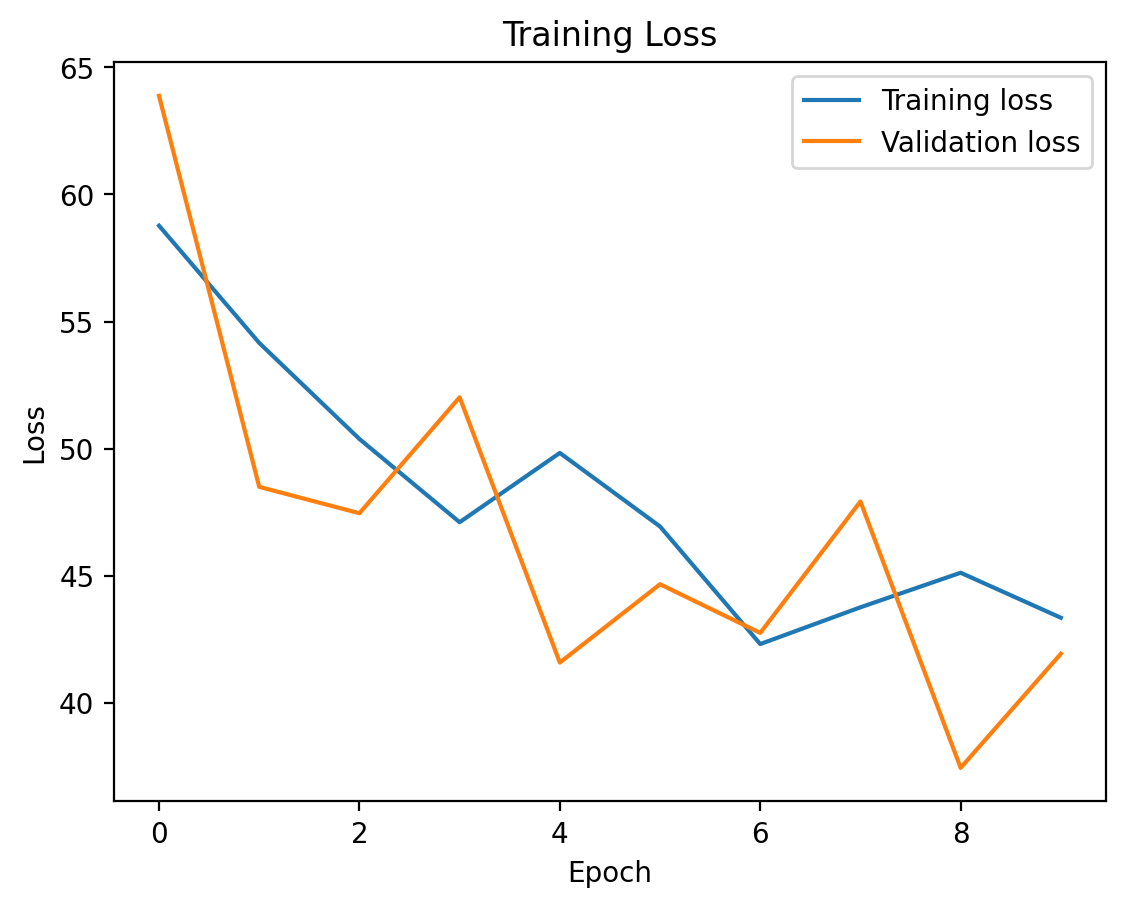

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_one_lstm(many_to_one_lstm, optimizer, criterion, 10, [], [], create_plot=True)

It doesn't go down as quickly, but still it goes down significantly. Let's see the next 30 epochs:

<ipython-input-12-4cbeee087625>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]


Average Train Loss: 39.7984
Average Validation Loss: 39.0082


Epoch 2:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 38.3060


Average Validation Loss: 47.6668


Epoch 3:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 35.9697


Average Validation Loss: 32.5327


Epoch 4:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 35.7591


Average Validation Loss: 44.6679


Epoch 5:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 37.7797


Average Validation Loss: 32.9688


Epoch 6:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 37.6595


Average Validation Loss: 37.3476


Epoch 7:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 35.5099


Average Validation Loss: 25.3891


Epoch 8:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 32.3397


Average Validation Loss: 27.0958


Epoch 9:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 33.0811


Average Validation Loss: 29.6482


Epoch 10:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 32.4283


Average Validation Loss: 34.7855


Epoch 11:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 32.3573


Average Validation Loss: 27.4348


Epoch 12:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 31.6640


Average Validation Loss: 29.9703


Epoch 13:: 100%|██████████| 31/31 [00:51<00:00,  1.66s/it]

Average Train Loss: 29.1454


Average Validation Loss: 23.2977


Epoch 14:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 29.9514


Average Validation Loss: 26.8374


Epoch 15:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 29.2916


Average Validation Loss: 29.1799


Epoch 16:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 28.3430


Average Validation Loss: 31.3860


Epoch 17:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 27.3189


Average Validation Loss: 32.1064


Epoch 18:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 27.0413


Average Validation Loss: 25.4063


Epoch 19:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 25.5335


Average Validation Loss: 24.7030


Epoch 20:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 24.6153


Average Validation Loss: 25.8213


Epoch 21:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 24.0207


Average Validation Loss: 24.2445


Epoch 22:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 24.6799


Average Validation Loss: 17.6611


Epoch 23:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 23.3331


Average Validation Loss: 24.3171


Epoch 24:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 23.6859


Average Validation Loss: 23.3682


Epoch 25:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]

Average Train Loss: 23.2611


Average Validation Loss: 15.4486


Epoch 26:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 22.0673


Average Validation Loss: 24.4357


Epoch 27:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]


Average Train Loss: 22.1316
Average Validation Loss: 22.2414


Epoch 28:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]

Average Train Loss: 20.8416


Average Validation Loss: 19.1642


Epoch 29:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 22.1533


Average Validation Loss: 16.5116


Epoch 30:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 21.6860


Average Validation Loss: 17.4137


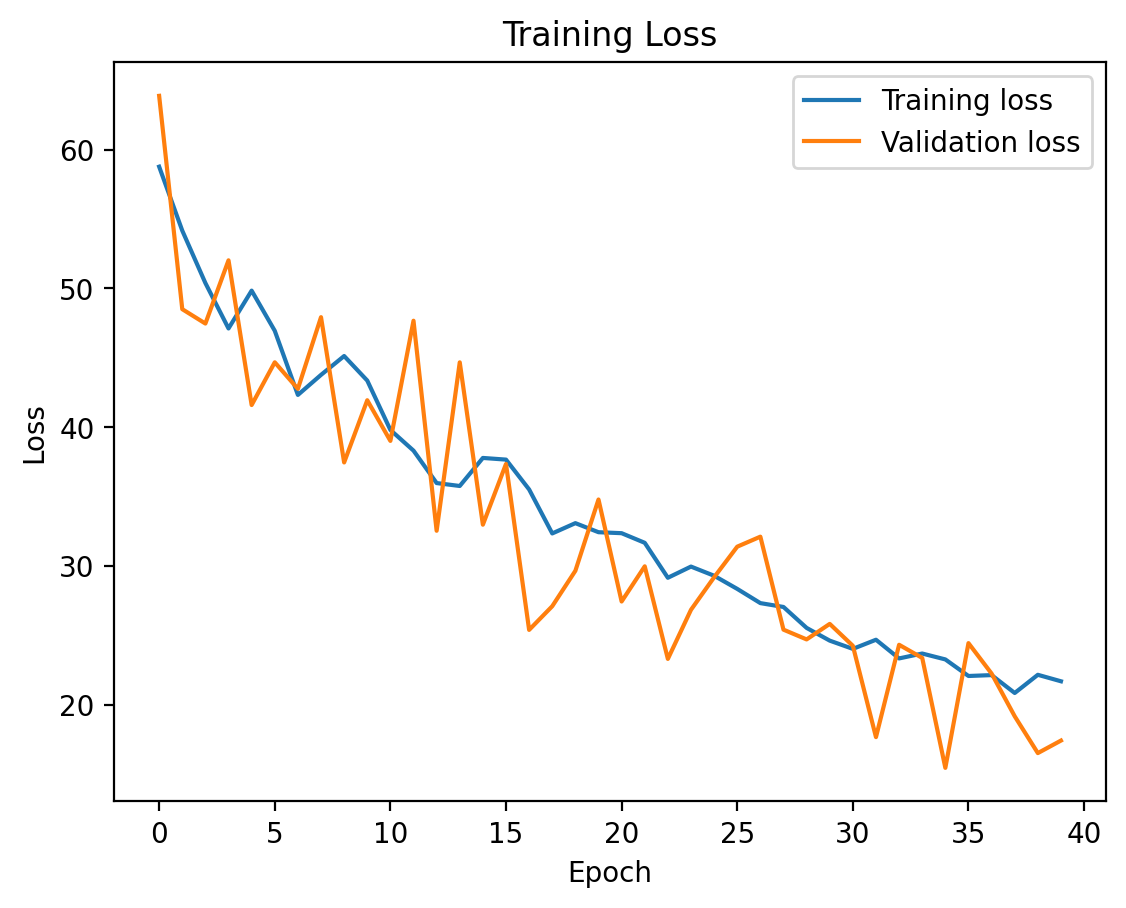

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_one_lstm(many_to_one_lstm, optimizer, criterion, 30, train_loss_history, val_loss_history, create_plot=True)

Okay, still a downward trend for both the train and validation sets. That's good news. Let's again make the epochs 150 and see what we've got:

<ipython-input-12-4cbeee087625>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 21.9855


Average Validation Loss: 21.1134


Epoch 2:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 21.8400


Average Validation Loss: 21.2380


Epoch 3:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 20.2268


Average Validation Loss: 21.2914


Epoch 4:: 100%|██████████| 31/31 [00:58<00:00,  1.89s/it]

Average Train Loss: 20.0679


Average Validation Loss: 16.3884


Epoch 5:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Train Loss: 19.7616


Average Validation Loss: 19.5642


Epoch 6:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 18.0941


Average Validation Loss: 20.7221


Epoch 7:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 19.4442


Average Validation Loss: 16.2801


Epoch 8:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 18.0735


Average Validation Loss: 18.5477


Epoch 9:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 17.7894


Average Validation Loss: 12.6749


Epoch 10:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 17.3009


Average Validation Loss: 13.3126


Epoch 11:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 18.0604


Average Validation Loss: 18.3434


Epoch 12:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 21.2158


Average Validation Loss: 14.8410


Epoch 13:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Average Train Loss: 15.9584


Average Validation Loss: 15.7006


Epoch 14:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 15.7728


Average Validation Loss: 13.5688


Epoch 15:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 16.3070


Average Validation Loss: 15.1782


Epoch 16:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 17.7507


Average Validation Loss: 11.9954


Epoch 17:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 16.7438


Average Validation Loss: 11.7010


Epoch 18:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 16.1522


Average Validation Loss: 15.7911


Epoch 19:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 18.2603


Average Validation Loss: 13.6939


Epoch 20:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 13.4490


Average Validation Loss: 14.2041


Epoch 21:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 14.2857


Average Validation Loss: 16.6242


Epoch 22:: 100%|██████████| 31/31 [00:57<00:00,  1.87s/it]

Average Train Loss: 14.8843


Average Validation Loss: 13.9921


Epoch 23:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 13.6225


Average Validation Loss: 15.3065


Epoch 24:: 100%|██████████| 31/31 [00:58<00:00,  1.87s/it]

Average Train Loss: 13.9816


Average Validation Loss: 11.7300


Epoch 25:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 14.5161


Average Validation Loss: 12.0625


Epoch 26:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


Average Train Loss: 14.6203
Average Validation Loss: 19.3648


Epoch 27:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 14.2101


Average Validation Loss: 11.8686


Epoch 28:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 14.1580


Average Validation Loss: 13.1780


Epoch 29:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 12.7247


Average Validation Loss: 12.5274


Epoch 30:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 13.8605


Average Validation Loss: 11.4150


Epoch 31:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 13.6347


Average Validation Loss: 16.7205


Epoch 32:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Train Loss: 12.0217


Average Validation Loss: 12.2476


Epoch 33:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 10.9934


Average Validation Loss: 13.5773


Epoch 34:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 12.2625


Average Validation Loss: 10.0184


Epoch 35:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 12.7215


Average Validation Loss: 10.9442


Epoch 36:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 13.3302


Average Validation Loss: 15.0592


Epoch 37:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]


Average Train Loss: 10.9826
Average Validation Loss: 14.9362


Epoch 38:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]

Average Train Loss: 13.4137


Average Validation Loss: 12.6597


Epoch 39:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 12.7215


Average Validation Loss: 13.1255


Epoch 40:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 11.7356


Average Validation Loss: 17.7516


Epoch 41:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 13.2614


Average Validation Loss: 17.6812


Epoch 42:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 11.6996


Average Validation Loss: 10.5807


Epoch 43:: 100%|██████████| 31/31 [00:52<00:00,  1.68s/it]


Average Train Loss: 12.3916
Average Validation Loss: 10.9883


Epoch 44:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 12.0289


Average Validation Loss: 12.3378


Epoch 45:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 13.0273


Average Validation Loss: 9.1800


Epoch 46:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Average Train Loss: 12.3067


Average Validation Loss: 10.1240


Epoch 47:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]


Average Train Loss: 12.1550
Average Validation Loss: 9.1549


Epoch 48:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 12.5485


Average Validation Loss: 10.8620


Epoch 49:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]

Average Train Loss: 11.4527


Average Validation Loss: 14.2896


Epoch 50:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 11.6305


Average Validation Loss: 14.5420


Epoch 51:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 10.4084


Average Validation Loss: 7.7753


Epoch 52:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 12.4136


Average Validation Loss: 14.2905


Epoch 53:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 10.8400


Average Validation Loss: 9.2448


Epoch 54:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 11.0261


Average Validation Loss: 8.1331


Epoch 55:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 10.1257


Average Validation Loss: 11.2064


Epoch 56:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


Average Train Loss: 9.2538
Average Validation Loss: 11.1671


Epoch 57:: 100%|██████████| 31/31 [00:52<00:00,  1.68s/it]

Average Train Loss: 10.9892


Average Validation Loss: 8.6832


Epoch 58:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Train Loss: 10.0464


Average Validation Loss: 11.7360


Epoch 59:: 100%|██████████| 31/31 [00:58<00:00,  1.90s/it]

Average Train Loss: 11.3619


Average Validation Loss: 19.2739


Epoch 60:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 9.6055


Average Validation Loss: 14.0221


Epoch 61:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Train Loss: 10.1400


Average Validation Loss: 10.1875


Epoch 62:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]


Average Train Loss: 9.6747
Average Validation Loss: 11.9698


Epoch 63:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 9.5748


Average Validation Loss: 11.8596


Epoch 64:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 9.0663


Average Validation Loss: 9.3915


Epoch 65:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 9.3238


Average Validation Loss: 7.3088


Epoch 66:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 8.6482


Average Validation Loss: 10.7231


Epoch 67:: 100%|██████████| 31/31 [00:55<00:00,  1.81s/it]

Average Train Loss: 10.4336


Average Validation Loss: 14.2171


Epoch 68:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 10.3883


Average Validation Loss: 9.8646


Epoch 69:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 9.4688


Average Validation Loss: 9.0612


Epoch 70:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 8.4118


Average Validation Loss: 8.8939


Epoch 71:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 10.1858


Average Validation Loss: 7.8204


Epoch 72:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 8.9855


Average Validation Loss: 11.8304


Epoch 73:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 8.9602


Average Validation Loss: 11.6339


Epoch 74:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 8.9920


Average Validation Loss: 9.6488


Epoch 75:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 9.2623


Average Validation Loss: 6.8126


Epoch 76:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 9.7358


Average Validation Loss: 9.4033


Epoch 77:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 9.9383


Average Validation Loss: 15.9277


Epoch 78:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]

Average Train Loss: 8.3550


Average Validation Loss: 12.6274


Epoch 79:: 100%|██████████| 31/31 [00:59<00:00,  1.93s/it]

Average Train Loss: 8.7569


Average Validation Loss: 9.5642


Epoch 80:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]


Average Train Loss: 8.8720
Average Validation Loss: 7.2711


Epoch 81:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 7.8525


Average Validation Loss: 10.0348


Epoch 82:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 11.2556


Average Validation Loss: 10.4671


Epoch 83:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 9.6874


Average Validation Loss: 8.9579


Epoch 84:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]


Average Train Loss: 10.3071
Average Validation Loss: 9.4922


Epoch 85:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 7.9567


Average Validation Loss: 9.2404


Epoch 86:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 9.6858


Average Validation Loss: 7.8938


Epoch 87:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 7.8901


Average Validation Loss: 10.5739


Epoch 88:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]


Average Train Loss: 9.0152
Average Validation Loss: 9.9309


Epoch 89:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 8.4346


Average Validation Loss: 6.1115


Epoch 90:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 8.2043


Average Validation Loss: 5.7033


Epoch 91:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 7.7600


Average Validation Loss: 9.1846


Epoch 92:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Average Train Loss: 7.7850


Average Validation Loss: 6.5954


Epoch 93:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 8.6930


Average Validation Loss: 11.1345


Epoch 94:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 8.0042


Average Validation Loss: 8.5479


Epoch 95:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 7.0063


Average Validation Loss: 10.5144


Epoch 96:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 8.5474


Average Validation Loss: 7.6745


Epoch 97:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 7.2403


Average Validation Loss: 7.2599


Epoch 98:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 8.3172


Average Validation Loss: 7.1003


Epoch 99:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 7.6935


Average Validation Loss: 8.0722


Epoch 100:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Average Train Loss: 8.1987


Average Validation Loss: 10.6032


Epoch 101:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 7.7036


Average Validation Loss: 6.9262


Epoch 102:: 100%|██████████| 31/31 [00:51<00:00,  1.68s/it]

Average Train Loss: 7.4764


Average Validation Loss: 7.0465


Epoch 103:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 6.8719


Average Validation Loss: 8.5632


Epoch 104:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 8.1124


Average Validation Loss: 5.0192


Epoch 105:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 7.4333


Average Validation Loss: 7.9164


Epoch 106:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 7.7527


Average Validation Loss: 4.0031


Epoch 107:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 8.4463


Average Validation Loss: 6.5842


Epoch 108:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 7.6372


Average Validation Loss: 8.4676


Epoch 109:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 7.3285


Average Validation Loss: 8.8131


Epoch 110:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 7.0655


Average Validation Loss: 5.4693


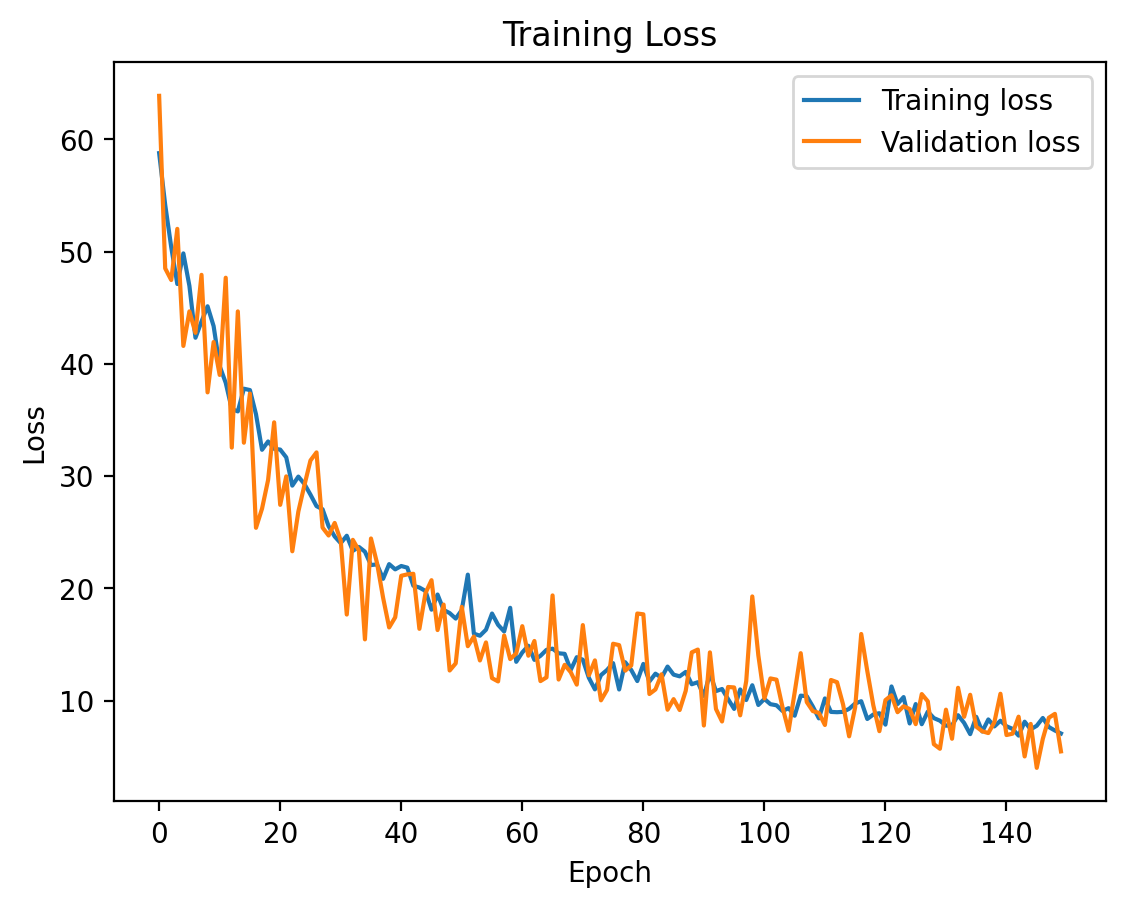

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_one_lstm(many_to_one_lstm, optimizer, criterion, 110, train_loss_history, val_loss_history, create_plot=True)

We can see, that the loss decrease has slowed down significantly. This may be a right time to stop the training.